In [1]:
import os
import pandas as pd
import json
from collections import Counter
import seaborn as sns
from netpixi.integration.gt import *
from netpixi.integration.gt import Graph
from regression.integration.gt import *
import netpixi
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import cpnet
from graph_tool import spectral

import numpy as np
from collections import defaultdict
import itertools
g = Graph(directed=False)
files = os.listdir('./jsons')

json_files = [file for file in files if file.endswith('.json')]

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


Na célula a seguir pegamos todas as informações encontradas nos arquivos JSON e juntamos em um dataframe.

In [2]:
df_combined = pd.DataFrame()

for json_file in json_files:
    data = []
    with open(f"jsons/{json_file}", 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                pass
    df = pd.DataFrame(data)
    df_combined = pd.concat([df_combined, df], ignore_index=True)
print(len(df_combined))

13707


In [3]:
df_combined.columns

Index(['apiURLs', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'descriptions', 'dimension', 'domains', 'ean', 'ean13',
       'features', 'gtins', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'merchants', 'mostRecentPriceAmount',
       'mostRecentPriceNonSalesAmount', 'mostRecentPriceAvailability',
       'mostRecentPriceCurrency', 'mostRecentPriceColor',
       'mostRecentPriceIsSale', 'mostRecentPriceDomain',
       'mostRecentPriceSourceURL', 'mostRecentPriceDate',
       'mostRecentPriceFirstDateSeen', 'mostRecentPriceByDomain', 'name',
       'prices', 'primaryCategories', 'primaryImageURLs', 'quantities',
       'reviews', 'secondaryCategories', 'skus', 'sourceURLs', 'taxonomy',
       'taxonomyLevel1', 'taxonomyLevel2', 'taxonomyLevel3', 'taxonomyLevel4',
       'taxonomyLevel5', 'taxonomyLevel6', 'taxonomyLevel7', 'upc', 'upca',
       'websiteIDs', 'weight', 'id', 'financingAndLeasing', 'sizes',
       'mostRecentPriceCondi

Pegamos todos os usuários dentro de todos os reviews

In [4]:
usuarios = []
ratings = []
for reviews_produto in df_combined['reviews']:
    ratings_produto = []
    for review in reviews_produto:
        if 'username' in review.keys():
            usuarios.append(review['username'])
        if 'rating' in review.keys():
            ratings_produto.append(review['rating'])
    ratings.append(sum(ratings_produto)/len(ratings_produto))

In [5]:
len(ratings)

13707

In [6]:
from collections import defaultdict

product_reviewers = defaultdict(list)

for i, row in df_combined.iterrows():
    for review in row['reviews']:
        if 'username' in review.keys() and 'rating' in review.keys():
            username = review['username']
            product_name = row['name']
            product_reviewers[product_name].append(username)

new_df = pd.DataFrame(list(product_reviewers.items()), columns=['product_name', 'usernames'])

new_df

,product_name,usernames
0,"ThinkVision T23d 22.5"" LED Monitor (HDMI, DP, ...","[Gomi, Terryc, myOwnTwoCents, Justin from Mich..."
1,"ThinkVision M14t 14"" LED Mobile Monitor with T...","[RogueStudio, Vvvsss, Anonymous, Zusan, Jenni2..."
2,"ThinkCentre Tiny-In-One 24 Gen 4 23.8"" IPS LCD...","[Robert W in TX, ucvb9, ucvb9, AlanS3, Robert ..."
3,"ThinkVision T22v-20 21.5"" VoIP LED Monitor (HD...","[MDREAM, Kent A, Norm01, Anonymous, Sam W, Ric..."
4,Legion KM300 Full-size Wired RGB Gaming Keyboa...,"[BCarter · Review provided by lenovo.com, fwi..."
...,...,...
12967,Frigidaire FDB2410HIC - Dishwasher - built-in ...,"[Lupe51, nanapattiann, Bobbi, Ruthie, kkdidit2..."
12968,"FRIGIDAIRE FFCD2418UW0A 24"" Built-In Dishwashe...","[Stealmonkey, The ok dishwasher, Randa, Dishwa..."
12969,"Frigidaire Gallery 8,000 BTU Window Air Condit...","[Review provided by Overstock.com, Jon_M, 246..."
12970,"Frigidaire® Top Freezer Refrigerator, 18 Cu. Ft.","[TheHenees, Blanca63, Large and roomy, Cougdud..."


In [7]:
from collections import defaultdict

product_reviewers = defaultdict(lambda: defaultdict(list))

for i, row in df_combined.iterrows():
    for review in row['reviews']:
        if 'username' in review.keys() and 'rating' in review.keys():
            username = review['username']
            rating_medio = review['rating']
            product_name = row['name']
            product_reviewers[product_name]['usernames'].append(username)
            product_reviewers[product_name]['ratings'].append(rating_medio)

# Convert the defaultdict to a list of dictionaries
data = [{'product_name': k, 'usernames': v['usernames'], 'ratings': v['ratings']} 
        for k, v in product_reviewers.items()]

# Create a new DataFrame
new_df = pd.DataFrame(data)

In [8]:
new_df

,product_name,usernames,ratings
0,"ThinkVision T23d 22.5"" LED Monitor (HDMI, DP, ...","[Gomi, Terryc, myOwnTwoCents, Justin from Mich...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, ..."
1,"ThinkVision M14t 14"" LED Mobile Monitor with T...","[RogueStudio, Vvvsss, Anonymous, Zusan, Jenni2...","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,"ThinkCentre Tiny-In-One 24 Gen 4 23.8"" IPS LCD...","[Robert W in TX, ucvb9, ucvb9, AlanS3, Robert ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, ..."
3,"ThinkVision T22v-20 21.5"" VoIP LED Monitor (HD...","[MDREAM, Kent A, Norm01, Anonymous, Sam W, Ric...","[5.0, 5.0, 5.0, 3.0, 4.0, 5.0, 1.0, 5.0, 5.0, ..."
4,Legion KM300 Full-size Wired RGB Gaming Keyboa...,"[BCarter · Review provided by lenovo.com, fwi...","[5.0, 3.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, ..."
...,...,...,...
12967,Frigidaire FDB2410HIC - Dishwasher - built-in ...,"[Lupe51, nanapattiann, Bobbi, Ruthie, kkdidit2...","[5.0, 2.0, 5.0, 5.0, 1.0, 5.0, 4.0, 1.0, 5.0, ..."
12968,"FRIGIDAIRE FFCD2418UW0A 24"" Built-In Dishwashe...","[Stealmonkey, The ok dishwasher, Randa, Dishwa...","[5.0, 4.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0, 5.0, ..."
12969,"Frigidaire Gallery 8,000 BTU Window Air Condit...","[Review provided by Overstock.com, Jon_M, 246...","[4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, ..."
12970,"Frigidaire® Top Freezer Refrigerator, 18 Cu. Ft.","[TheHenees, Blanca63, Large and roomy, Cougdud...","[5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, ..."


In [9]:
ratings = []
for i, row in new_df.iterrows():
    ratings.append(sum(row['ratings'])/len(row['ratings']))
    

In [10]:
new_df['rating_medio'] = ratings

In [11]:
new_df

,product_name,usernames,ratings,rating_medio
0,"ThinkVision T23d 22.5"" LED Monitor (HDMI, DP, ...","[Gomi, Terryc, myOwnTwoCents, Justin from Mich...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, ...",4.786885
1,"ThinkVision M14t 14"" LED Mobile Monitor with T...","[RogueStudio, Vvvsss, Anonymous, Zusan, Jenni2...","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",4.581395
2,"ThinkCentre Tiny-In-One 24 Gen 4 23.8"" IPS LCD...","[Robert W in TX, ucvb9, ucvb9, AlanS3, Robert ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, ...",4.645161
3,"ThinkVision T22v-20 21.5"" VoIP LED Monitor (HD...","[MDREAM, Kent A, Norm01, Anonymous, Sam W, Ric...","[5.0, 5.0, 5.0, 3.0, 4.0, 5.0, 1.0, 5.0, 5.0, ...",4.344262
4,Legion KM300 Full-size Wired RGB Gaming Keyboa...,"[BCarter · Review provided by lenovo.com, fwi...","[5.0, 3.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, ...",4.736842
...,...,...,...,...
12967,Frigidaire FDB2410HIC - Dishwasher - built-in ...,"[Lupe51, nanapattiann, Bobbi, Ruthie, kkdidit2...","[5.0, 2.0, 5.0, 5.0, 1.0, 5.0, 4.0, 1.0, 5.0, ...",3.700000
12968,"FRIGIDAIRE FFCD2418UW0A 24"" Built-In Dishwashe...","[Stealmonkey, The ok dishwasher, Randa, Dishwa...","[5.0, 4.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0, 5.0, ...",3.000000
12969,"Frigidaire Gallery 8,000 BTU Window Air Condit...","[Review provided by Overstock.com, Jon_M, 246...","[4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, ...",4.321995
12970,"Frigidaire® Top Freezer Refrigerator, 18 Cu. Ft.","[TheHenees, Blanca63, Large and roomy, Cougdud...","[5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, ...",4.900000


Fazemos o sampling do dataframe, pois ele é muito grande e um computador comum seria incapaz de rodar todo o 
código a seguir com um dataframe tão grande

In [12]:
dicionario = {}

for i, row in new_df.iterrows():
    dicionario[row['product_name']] = row['rating_medio']

In [13]:
df_sample = new_df.sample(n=2000, random_state = 42)
print(len(df_sample))

2000


In [14]:
df_sample

,product_name,usernames,ratings,rating_medio
5030,HP 123A LaserJet Toner Cartridge - Yellow,"[Anonymous, Anonymous, Aaron O., Aaron O.]","[5.0, 5.0, 5.0, 5.0]",5.000000
6312,"Dell Inspiron 7370 - i5-8250U - 13.3"" - 8GB RA...","[NK Tulsa, Mike168, Adahy, kitchenman, Nath, k...","[1.0, 5.0, 4.0, 1.0, 3.0, 5.0, 4.0, 4.0, 4.0]",3.444444
304,"Lenovo IdeaPad 15.6"" Laptop, Intel Core i3 i3-...","[Wally, TJ18, Csh0032, DonMc, Moonintheburgh, ...","[5.0, 4.0, 5.0, 5.0, 1.0, 1.0, 5.0, 3.0, 5.0, ...",3.622951
6286,"Dell Inspiron 15.6"" Full HD Touchscreen Laptop...","[Amazon Customer, Big critic or supporter, xia...","[3.0, 3.0, 5.0, 1.0, 1.0, 5.0, 4.0]",3.142857
4441,LaserJet Pro M255dw Wireless Color Laser Printer,"[Unique Nickname 2, NorthernWeaver · Review pr...","[2.0, 5.0, 1.0, 5.0, 5.0, 4.0, 2.0, 1.0, 2.0, ...",3.619171
...,...,...,...,...
11562,JBL CLUB ONE Noise-Canceling Wireless Over-Ear...,"[Samsungjunky · Review provided by Best Buy, ...","[3.0, 2.0, 4.0, 5.0, 1.0, 4.0, 1.0, 5.0, 4.0, ...",4.000000
9932,BenQ 1080P 3D HD Short Throw Home Theater Proj...,"[Emily, Tcass · Review provided by bestbuy.ca...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",4.918367
7387,DJI Ronin-SC RSS Control Cable for Fujifilm Ca...,[Robert],[4.0],4.000000
5263,HP Color LaserJet Pro M452dw - printer - color...,[Maria H.],[5.0],5.000000


In [15]:
df = df_sample.explode('usernames')


pivot_table = df.groupby(['usernames','product_name']).size().unstack(fill_value=0)

new_df_data = []
for _, row in pivot_table.iterrows():
    reviewed_products = row[row > 0].index.tolist()
    
    for product1, product2 in combinations(reviewed_products, 2):
        new_df_data.append((f"{product1}_{product2}", 1))

new_df = pd.DataFrame(new_df_data, columns=['product_pair', 'weight'])

new_df = new_df.groupby('product_pair').sum().reset_index()

In [16]:
new_df

,product_pair,weight
0,(New) JBL OnBeat Micro Speaker Dock with Light...,1
1,(New) JBL OnBeat Micro Speaker Dock with Light...,1
2,(New) JBL OnBeat Micro Speaker Dock with Light...,1
3,(New) JBL OnBeat Micro Speaker Dock with Light...,1
4,(New) JBL OnBeat Micro Speaker Dock with Light...,1
...,...,...
442593,iPhone 12 Pro Max Clear Case with MagSafe_iPho...,5
442594,iPhone 12 Pro Max Clear Case with MagSafe_iPho...,10
442595,iPhone 12 Pro Max Clear Case with MagSafe_xb1 ...,1
442596,iPhone 12 Pro Max Silicone Case with MagSafe_i...,11


In [17]:
df_novo_dataset = new_df.groupby('weight').size().reset_index(name='count')

df_filtrado = df_novo_dataset.loc[df_novo_dataset['weight'] < 26]
df_filtrado

,weight,count
0,1,339559
1,2,56661
2,3,19692
3,4,9193
4,5,5217
5,6,3080
6,7,2115
7,8,1426
8,9,1093
9,10,846


In [18]:
new_df = new_df.loc[new_df['weight'] >= 2]
new_df

,product_pair,weight
14,(New) JBL OnBeat Micro Speaker Dock with Light...,2
15,(New) JBL OnBeat Micro Speaker Dock with Light...,2
57,- Kingston 240GB 2.5-inch 6GB/s HyperX 3K MLC ...,2
81,- Kingston 240GB 2.5-inch 6GB/s HyperX 3K MLC ...,3
106,- Kingston 240GB 2.5-inch 6GB/s HyperX 3K MLC ...,2
...,...,...
442590,iPhone 12 12 Pro Leather Case with MagSafe - S...,3
442592,iPhone 12 12 Pro Leather Case with MagSafe - S...,4
442593,iPhone 12 Pro Max Clear Case with MagSafe_iPho...,5
442594,iPhone 12 Pro Max Clear Case with MagSafe_iPho...,10


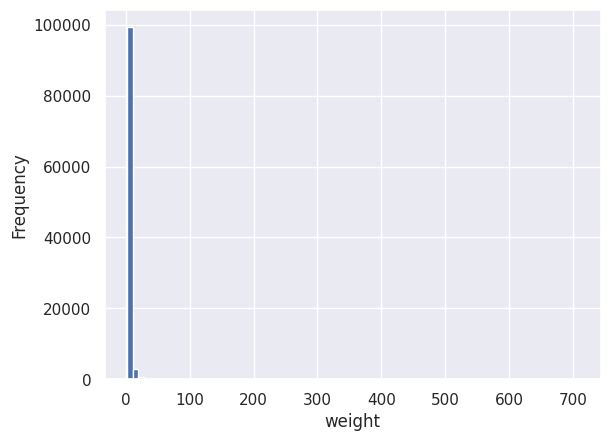

In [19]:
new_df["weight"].plot.hist(bins=80)
plt.xlabel("weight")
plt.show()

In [20]:
import csv
from collections import defaultdict
from itertools import combinations
from sklearn.preprocessing import LabelEncoder

username_counts = defaultdict(int)

for username, row in pivot_table.iterrows():
    if username in ['Anonymous', 'anonymous', 'ByAmazonCustomer', 'Amazon Customer']:
        continue

    reviewed_products = row[row > 0].index.tolist()

    username_counts[username] += len(reviewed_products)

data_dict = defaultdict(list)

for username, row in pivot_table.iterrows():

    reviewed_products = row[row > 0].index.tolist()

    for product1, product2 in combinations(reviewed_products, 2):
        data_dict[(product1, product2)].append(username)

new_df = pd.DataFrame(list(data_dict.items()), columns=['product_pair', 'usernames'])

new_df['weight'] = new_df['usernames'].apply(len)

new_df = new_df[new_df['weight'] >= 4]

product_encoder = LabelEncoder()

all_product_names = set([product for pair in new_df['product_pair'] for product in pair])

product_encoder.fit(list(all_product_names))

with open('edges.txt', 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    for _, row in new_df.iterrows():
        product1, product2 = row['product_pair']
        encoded_product1 = product_encoder.transform([product1])[0]
        encoded_product2 = product_encoder.transform([product2])[0]
        writer.writerow([encoded_product1, encoded_product2])


<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [21]:
new_df

,product_pair,usernames,weight
0,"(Canon CLI-281 XXL Black Ink Tank (11.7mL), Ca...","["" · Review provided by staples.com, DAN · Re...",4
1,"(Canon CLI-281 XXL Black Ink Tank (11.7mL), Ca...","["" · Review provided by staples.com, DAN · Re...",12
6,"(Canon CLI-8 Ink Cartridge - Yellow, Canon PGI...","["" · Review provided by staples.com, Anonymou...",11
16,(Epson T288XL Yellow High Yield Ink Cartridge ...,"["" · Review provided by staples.com, CAROL M....",4
21,(Nikon - D7200 DSLR Camera (Body Only) - Black...,"[$pare$tuff · Review provided by ebay.com, DA...",14
...,...,...,...
427659,(Certified Refurbished - Apple 10.2-Inch iPad ...,"[Robert, Ronald, Susan, Tim]",4
430274,(Nintendo Blue/ Neon Yellow Joy-Con (L-R) - Sw...,"[Robert, Scott, Vanessa, Will]",4
432180,"(Samsung - 70"" Class Q60a Series Qled 4k Uhd S...",[Samsung2021Buyer · Review provided by samsun...,5
432182,"(Samsung Q70A 85"" Class HDR 4K UHD Smart QLED ...",[Samsung2021Buyer · Review provided by samsun...,5


In [22]:
f = open("edges.txt", "r")
x = f.readlines()

vertices = []
i = 0
while i <= len(x)-1:
    z = x[i].split('\t')
    y = z[1].strip('\n')
    if z[0] not in vertices:
        vertices.append(int(z[0]))
    if y not in vertices:
        vertices.append(int(y))
    if i%1000 == 0:
        print(i)
    i +=1
vertices = list(dict.fromkeys(vertices) )

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


In [23]:
for v in vertices:
    g.add_vertex(v)
print('número de vértices de g:', g.num_vertices())

número de vértices de g: 930


In [24]:
i = 0
while i <= len(x)-1:
    z = x[i].split('\t')
    y = int(z[1].strip('\n'))
    g.add_edge(int(z[0]), y)
    i +=1
    
print('número de arestas de g:', g.num_edges())

número de arestas de g: 26686


In [25]:
gt_save(g, 'products.net.gz')

In [26]:
g = gt_load('products.net.gz')

In [27]:
m = g.num_edges()
n = g.num_vertices()
print(f"Arestas = {m}")
print(f"Vertices = {n}")
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges
d = m / max_edges
print(f"Densidade = {d}")

Arestas = 26686
Vertices = 930
Densidade = 0.06177529312360383


In [28]:
data = gt_data(g)
data

""
id
205
207
224
318
403
...
136
82
374


In [29]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree'] = degrees
data

,degree
id,
205,51
207,4
224,16
318,6
403,45
...,...
136,1
82,3
374,1


count    930.000000
mean      57.389247
std       91.790332
min        1.000000
25%        3.000000
50%       13.000000
75%       71.000000
max      613.000000
Name: degree, dtype: float64

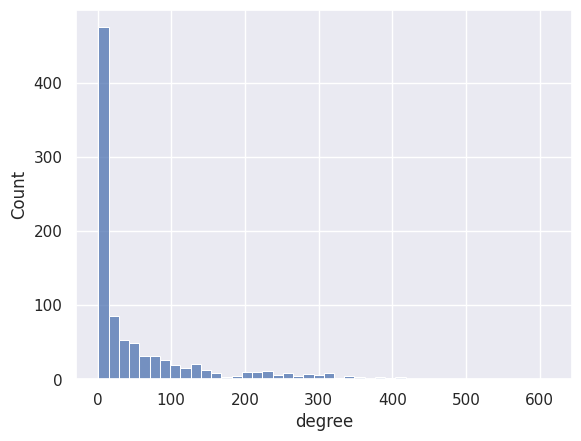

In [30]:
sns.histplot(data['degree'])
data['degree'].describe()

In [31]:
g = gt_load('products.net.gz')
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'exemplo.net.gz')
netpixi.render('exemplo.net.gz');

In [32]:
g = gt_clean(g)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'exemplo.net.gz')
r = netpixi.render('exemplo.net.gz', infinite=True);

In [33]:
matrix = spectral.adjacency(g)
algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c = algorithm.get_coreness()

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [34]:
g.add_vp('coreness')
for i, coreness in c.items():
    v = g.get_vertex_by_index(i)
    v['coreness'] = float(coreness)

for v in g.all_vertices():
    r.vertex(v['id'], size=(10 + 40 * v['coreness']))

In [35]:
df_single_product = new_df.explode('product_pair')

In [36]:
df_final = df_single_product.groupby('product_pair')['usernames'].count().reset_index()
df_final.columns = ['product', 'usernames_count']

In [37]:
df_final['coreness'] = df_final.index.map(c.get)

In [38]:
df_final = df_final.dropna()
df_final

,product,usernames_count,coreness
0,1 AW1 Waterproof Mirrorless Camera with 11-27....,8,0.239035
1,1.2 Cu. Ft. 1200 Watt SN66KB Microwave with In...,6,0.069444
2,"100S-14IBR 14"" Laptop - Intel Celeron - 2GB Me...",222,0.080775
3,1155W 7.2-Ch. with Dolby Atmos 4K Ultra HD HDR...,18,0.138523
4,2019 Google Pixel 3a XL 64GB LTE Cell Phone (U...,21,0.200292
...,...,...,...
851,Sony NP-FV100A V-Series Rechargeable Battery P...,26,0.055556
852,Sony NP-FV70A V-Series Battery Pack for Handyc...,84,0.016082
853,Sony NP-FW50 Lithium-Ion Rechargeable Battery ...,207,0.013889
854,Sony Np-fv100 Rechargeable Battery,1,0.053363


In [39]:
rating_medio_produto = []
for i, row in df_final.iterrows():
    rating_medio_produto.append(dicionario[row['product']])

In [40]:
df_final['rating_medio'] = rating_medio_produto

In [41]:
df_final

,product,usernames_count,coreness,rating_medio
0,1 AW1 Waterproof Mirrorless Camera with 11-27....,8,0.239035,2.846154
1,1.2 Cu. Ft. 1200 Watt SN66KB Microwave with In...,6,0.069444,4.037975
2,"100S-14IBR 14"" Laptop - Intel Celeron - 2GB Me...",222,0.080775,4.180036
3,1155W 7.2-Ch. with Dolby Atmos 4K Ultra HD HDR...,18,0.138523,3.987805
4,2019 Google Pixel 3a XL 64GB LTE Cell Phone (U...,21,0.200292,4.138889
...,...,...,...,...
851,Sony NP-FV100A V-Series Rechargeable Battery P...,26,0.055556,4.681818
852,Sony NP-FV70A V-Series Battery Pack for Handyc...,84,0.016082,4.460000
853,Sony NP-FW50 Lithium-Ion Rechargeable Battery ...,207,0.013889,4.102041
854,Sony Np-fv100 Rechargeable Battery,1,0.053363,4.636364


In [42]:
df_final.dtypes

product             object
usernames_count      int64
coreness           float64
rating_medio       float64
dtype: object

In [43]:
import regression as reg
result = reg.linear(data=df_final, formula='coreness ~ usernames_count')
result.micro_summary()   

variable,coefficient,std error,p-value
usernames_count,-0.000092,0.000112,0.414885


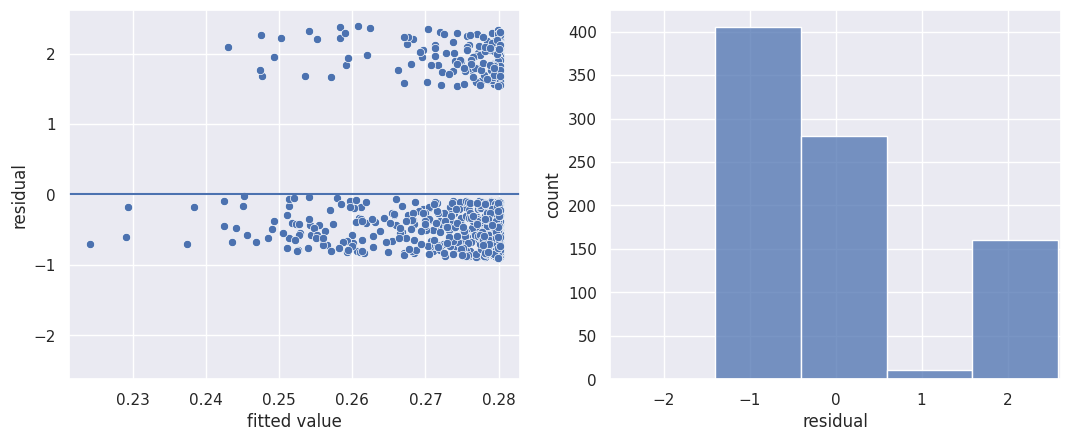

In [44]:
result.plot_residuals()

In [45]:
df_final.sort_values(by = 'coreness',
                      axis=0,
                      ascending=True,
                      inplace=False,
                      kind='quicksort',
                      na_position='last')

,product,usernames_count,coreness,rating_medio
27,8x External Double-Layer DVD±RW/CD-RW SuperMul...,1,0.000000,4.119266
845,Sony FE 28-60mm f/4-5.6 Lens,4,0.000365,4.475000
681,Panasonic Lumix GH5 Battery Grip - DMW-BGGH5,36,0.000731,3.513514
768,Samsung Galaxy S21 Ultra 5G - 512 GB - Phantom...,3,0.001096,3.394737
84,Amazon Echo Show 5 - Compact Smart Display wit...,143,0.001462,4.625000
...,...,...,...,...
383,HP - LaserJet Pro M402n Laser Printer,1,0.992733,4.164835
181,"BenQ 24.1"" 16:10 PhotoVue IPS Monitor",108,0.994186,4.687500
20,55” Class BRAVIA XR A90J Series OLED 4K UHD Sm...,4,0.995640,4.654545
125,Apple Watch SE - 44mm - GPS - Gold Aluminum Ca...,213,0.997093,4.833333


In [46]:
df_final

,product,usernames_count,coreness,rating_medio
0,1 AW1 Waterproof Mirrorless Camera with 11-27....,8,0.239035,2.846154
1,1.2 Cu. Ft. 1200 Watt SN66KB Microwave with In...,6,0.069444,4.037975
2,"100S-14IBR 14"" Laptop - Intel Celeron - 2GB Me...",222,0.080775,4.180036
3,1155W 7.2-Ch. with Dolby Atmos 4K Ultra HD HDR...,18,0.138523,3.987805
4,2019 Google Pixel 3a XL 64GB LTE Cell Phone (U...,21,0.200292,4.138889
...,...,...,...,...
851,Sony NP-FV100A V-Series Rechargeable Battery P...,26,0.055556,4.681818
852,Sony NP-FV70A V-Series Battery Pack for Handyc...,84,0.016082,4.460000
853,Sony NP-FW50 Lithium-Ion Rechargeable Battery ...,207,0.013889,4.102041
854,Sony Np-fv100 Rechargeable Battery,1,0.053363,4.636364


In [47]:
recorte1 = df_final.copy()
recorte2 = df_final.copy()

In [48]:
recorte1 = recorte1.loc[recorte1['rating_medio'] > 4]

In [49]:
recorte1

,product,usernames_count,coreness,rating_medio
1,1.2 Cu. Ft. 1200 Watt SN66KB Microwave with In...,6,0.069444,4.037975
2,"100S-14IBR 14"" Laptop - Intel Celeron - 2GB Me...",222,0.080775,4.180036
4,2019 Google Pixel 3a XL 64GB LTE Cell Phone (U...,21,0.200292,4.138889
6,24 A9-9425 8GB 1TB W10,1,0.203582,4.062500
9,"29"" IPS LED HD 21:9 Ultrawide Monitor",2,0.149123,4.105263
...,...,...,...,...
851,Sony NP-FV100A V-Series Rechargeable Battery P...,26,0.055556,4.681818
852,Sony NP-FV70A V-Series Battery Pack for Handyc...,84,0.016082,4.460000
853,Sony NP-FW50 Lithium-Ion Rechargeable Battery ...,207,0.013889,4.102041
854,Sony Np-fv100 Rechargeable Battery,1,0.053363,4.636364


In [50]:
result_recorte1 = reg.linear(data=recorte1, formula='coreness ~ usernames_count')
result_recorte1.micro_summary() 

variable,coefficient,std error,p-value
usernames_count,-0.000119,0.000125,0.340571


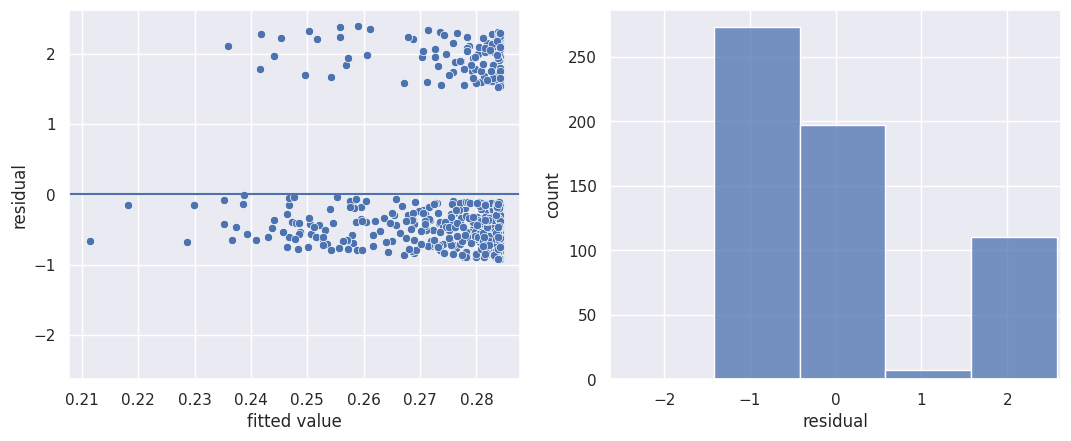

In [51]:
result_recorte1.plot_residuals()

In [52]:
# Explode the 'usernames' column
df_exploded = df_sample.explode('usernames')

# Count the number of occurrences for each username
user_counts = df_exploded['usernames'].value_counts()

# Convert the Series to a DataFrame and reset the index
user_counts_df = user_counts.reset_index()

# Rename the columns
user_counts_df.columns = ['username', 'count']
user_counts_df = user_counts_df[~user_counts_df['username'].isin(['Anonymous', 'Amazon Customer', 'ByAmazon Customer'])]

In [53]:
print(f"Temos {len(user_counts_df)} reviewers")
print(user_counts_df['count'].mean())
print(user_counts_df['count'].std())
threshold_above = 1
superusers_df = user_counts_df[(user_counts_df['count'] > threshold_above)]

Temos 88301 reviewers
1.5641498963771645
5.17262577912531


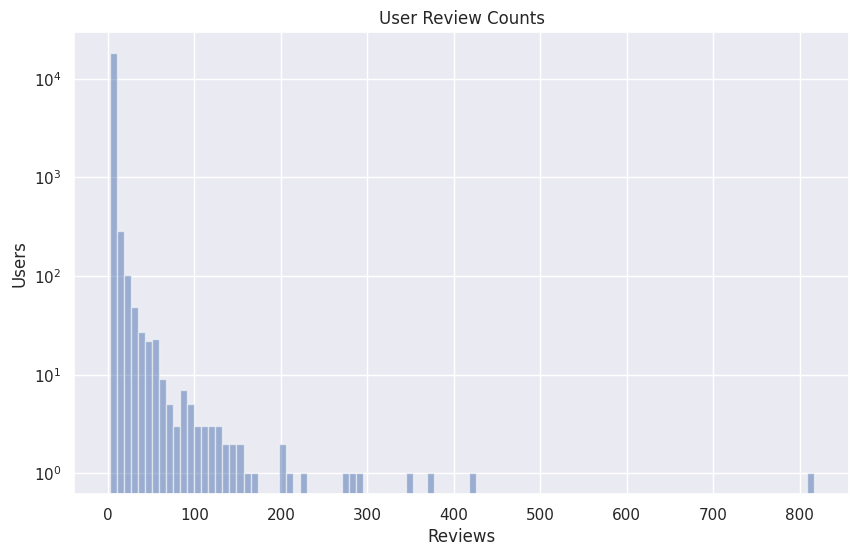

In [54]:
plt.figure(figsize=(10, 6))
plt.hist(superusers_df['count'], bins=100, alpha=0.5)
plt.yscale('log')  # to view the data in logarithmic scale
plt.title('User Review Counts')
plt.xlabel('Reviews')
plt.ylabel('Users')
plt.grid(True)
plt.show()

In [55]:
threshold = superusers_df['count'].quantile(0.99)
print(threshold)
superusers_df = user_counts_df[user_counts_df['count'] > threshold]
superusers_df

25.0


,username,count
1,samsung,817
3,John,419
4,Michael,375
5,David,346
6,lg,294
...,...,...
185,Disappointed,26
186,William · Review provided by bhphotovideo.com,26
187,Luke,26
188,Rafael,26


In [56]:
df_final

,product,usernames_count,coreness,rating_medio
0,1 AW1 Waterproof Mirrorless Camera with 11-27....,8,0.239035,2.846154
1,1.2 Cu. Ft. 1200 Watt SN66KB Microwave with In...,6,0.069444,4.037975
2,"100S-14IBR 14"" Laptop - Intel Celeron - 2GB Me...",222,0.080775,4.180036
3,1155W 7.2-Ch. with Dolby Atmos 4K Ultra HD HDR...,18,0.138523,3.987805
4,2019 Google Pixel 3a XL 64GB LTE Cell Phone (U...,21,0.200292,4.138889
...,...,...,...,...
851,Sony NP-FV100A V-Series Rechargeable Battery P...,26,0.055556,4.681818
852,Sony NP-FV70A V-Series Battery Pack for Handyc...,84,0.016082,4.460000
853,Sony NP-FW50 Lithium-Ion Rechargeable Battery ...,207,0.013889,4.102041
854,Sony Np-fv100 Rechargeable Battery,1,0.053363,4.636364


In [57]:
df_recorte_2 = df_single_product.groupby('product_pair')['usernames'].agg(list).reset_index()
df_recorte_2.columns = ['product', 'usernames']
df_recorte_2['usernames'] = df_recorte_2['usernames'].apply(lambda usernames_list: list(set([user for sublist in usernames_list for user in sublist])))

In [62]:
superuser_usernames = set.union(*df_recorte_2['usernames'].apply(set))

In [65]:
# Filter and keep only the superusers in the 'usernames' column of df_recorte_2
df_recorte_2['usernames'] = df_recorte_2['usernames'].apply(lambda usernames: [user for user in usernames if user in superuser_usernames])

In [66]:
df_recorte_2['username_count'] = df_recorte_2['usernames'].apply(len)
df_recorte_2['coreness'] = df_final.index.map(c.get)

ValueError: Length of values (856) does not match length of index (930)

In [ ]:
df_recorte_2

In [ ]:
df_recorte_2 = df_recorte_2[df_recorte_2['username_count'] >= 2]
df_recorte_2 = df_recorte_2.dropna()
df_recorte_2

In [ ]:
result = reg.linear(data=df_recorte_2, formula='coreness ~ username_count')
result.micro_summary()   

In [ ]:
result.plot_residuals()